# Model Selection and Evaluation - Part 2

## Activity  3 - Cross Validation

In the previous activity, we made the classic mistake of usin our test dataset to tune our model's
hyperparamters and to predict our generalization error. This tends to give misleadingly optimistic predictions about how well we will do on unobserved data. Remember that we carefully picked our hyperparameter values to do as well as possible *on our held-out data*. We shouldn't be surprised when our model performs better on that data than on unobserved data. This problem is particularly acute if our data set is small.

The traditional solution is to divide our data into three disjoint sets: **training**, **validation**, and **testing**:
* The **training** set is used to fit the model.
* The **validation** set is used to evaluate models for the purpose of hyperparameter selection. 
* The **test** set is kept in a locked room guarded by jaguars. We only look at the testing set ONCE, when we have finalized our model. That way our performance on the test set gives us an unbiased estimate of our generalization error.

This traditional approach is fine if we have a lot of data to work with. If the data set is small, we are faced with a painful dilemma: More validation data means better model selection. More testing data means more accurate model evaluation. More training data means better models. Any data we use for one purpose can't be used for the others.

**Cross validation** is one way to use limited data more effectively.  The cells below walk us through an example of using cross validation for hyperparameter tuning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from DTClassBounds import decision_areas, plot_areas  

from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap

dataset_size = 200
X, y = make_moons(n_samples=dataset_size, noise=0.3, random_state=0)

# Split our data into a training and testing set...
split_point = int(X.shape[0] * .8) # Use 80% of the data to train the model

X_train = X[0:split_point, :]
y_train = y[0:split_point]

X_test = X[split_point::, :] # This data will ONLY be used for final evaluation.
y_test = y[split_point::]

print('training and test creation complete')

training and test creation complete


The following cell shows how we can use the scikit-learn `KFold` class to automatically split up our **training** data for k-fold cross validation. Take a minute to read through this code to make sure you understand what's going on.

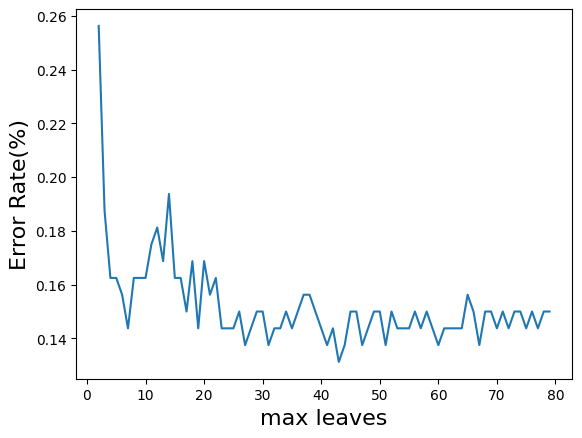

In [2]:
from sklearn.model_selection import KFold

FOLDS = 10
MAX_LEAVES = 80
kf = KFold(n_splits=FOLDS)

error_rates = np.zeros((FOLDS, MAX_LEAVES - 2)) # (can't have 0 or 1 leaves)

# Loop over all of the hyperparameter settings
for max_leaves in range(2, MAX_LEAVES):
    
    k = 0
    # Evaluate each one K-times
    for train_index, val_index in kf.split(X_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        tree = DecisionTreeClassifier(max_leaf_nodes=max_leaves)
        tree.fit(X_tr, y_tr)
        
        y_val_predict = tree.predict(X_val)
        error_rates[k, max_leaves - 2] = np.sum((y_val - y_val_predict)**2) / y_val.size
        
        k += 1
        
# Average across the k folds
error_rates_avg = np.mean(error_rates, axis=0)

plt.plot(np.arange(2, MAX_LEAVES), error_rates_avg)
plt.xlabel('max leaves', fontsize=16)
plt.ylabel('Error Rate(%)',fontsize=16)
plt.show()

# <span style="color:red">Question 10</span>

What is contained in the variables *train_index* and *val_index* during each loop 
iteration?  What is kf.split returning?

## *YOUR ANSWER HERE*

# Cross Validation with Scikit-Learn

Scikit-learn offers a framework to automate some of this by using the `cross_val_score` function:  

(There are also library routines for [automating the entire process of hyperparameter tuning](https://scikit-learn.org/stable/modules/grid_search.html).) 

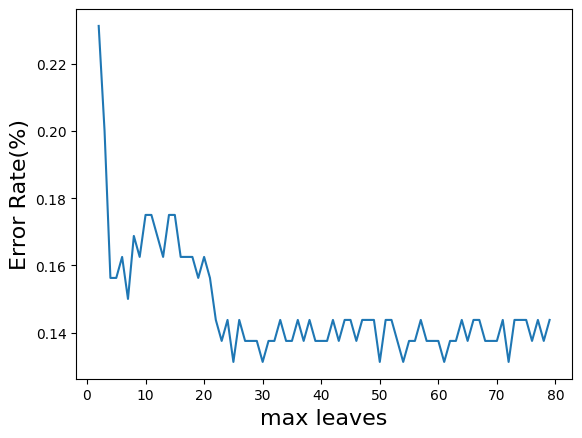

In [3]:
from sklearn.model_selection import cross_val_score

# 2d matrix, each fold has a row and each leaf setting is a column
error_rates = np.zeros((FOLDS, MAX_LEAVES - 2))

# Loop over all of the hyperparameter settings
for size in range(2, MAX_LEAVES):
    tree = DecisionTreeClassifier(max_leaf_nodes=size)
    
    # Returns an array of cross validation results.
    # NOTE: 1 - accuracy is the error_rate
    error_rates[:, size - 2] = 1 - cross_val_score(tree, X_train, y_train, 
                                         cv=FOLDS, scoring='accuracy')
    
error_rate_avg = np.mean(error_rates, axis=0)
smallds_error_rate_avg = error_rate_avg
model_plot_200 = plt.plot(np.arange(2, MAX_LEAVES), error_rate_avg)

plt.xlabel('max leaves', fontsize=16)
plt.ylabel('Error Rate(%)',fontsize=16)
plt.show()

# <span style="color:red">Question 11</span>


* Based on the results above, what is the most promising hyperparameter value?

# <span style="color:red">Answer 11</span>

* YOUR ANSWER HERE


# More Data Please

The plot of the cross-validation error rate did not make our decision of the hyperparameter easy.
In more complex applications of ML, this becomes much more difficult, especially when a model has many
different hyperparameters to tune and the models take significant time to construct.  

Let''s see if the choice of the single hyperparameter in this example becomes easier if
we just had more data.



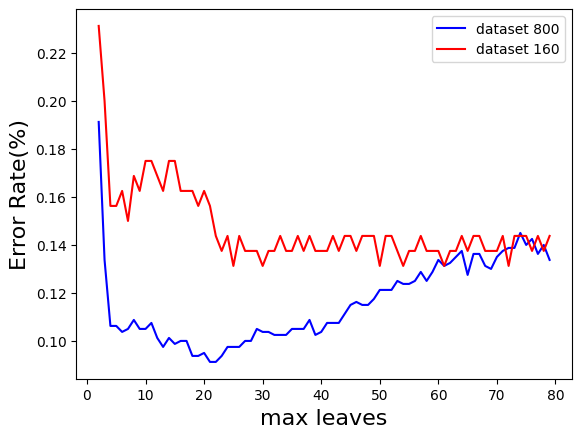

In [4]:
from sklearn.model_selection import cross_val_score

X_large, y_large = make_moons(n_samples=1000, noise=0.3, random_state=0)

# Split our data into a training and testing set...
split_point = int(X_large.shape[0] * .8) # Use 80% of the data to train the model

X_large_train = X_large[0:split_point, :]
y_large_train = y_large[0:split_point]

X_large_test = X_large[split_point::, :] 
y_large_test = y_large[split_point::]



# 2d matrix, each fold has a row and each leaf setting is a column
error_rates = np.zeros((FOLDS, MAX_LEAVES - 2))

# Loop over all of the hyperparameter settings
for size in range(2, MAX_LEAVES):
    tree = DecisionTreeClassifier(max_leaf_nodes=size)
    
    # Returns an array of cross validation results.
    # NOTE: 1 - accuracy is the error_rate
    error_rates[:, size - 2] = 1 - cross_val_score(tree, X_large_train, 
                                                   y_large_train, 
                                         cv=FOLDS, scoring='accuracy')
    
error_rate_avg = np.mean(error_rates, axis=0)

plt.clf()
plt.plot(np.arange(2, MAX_LEAVES), error_rate_avg,c = 'blue',
                   label='dataset ' + str(X_large_train.shape[0]))
plt.plot(np.arange(2, MAX_LEAVES), smallds_error_rate_avg, c = 'red',
                   label='dataset ' + str(X_train.shape[0]))


plt.xlabel('max leaves', fontsize=16)
plt.ylabel('Error Rate(%)',fontsize=16)

plt.legend()

plt.show()

Now that we have a value for our hyperparameter, let's train our final model on the *full* training set and use our locked-away testing set to predict model performance.

In [5]:
## Students -- modify code here

predictGenErrortree = DecisionTreeClassifier(max_leaf_nodes=???) # Put your best hyperparameter here!
# YOUR CODE HERE
raise NotImplementedError()

# Train using ALL the training data (smaller set)
predictGenErrortree.fit(X_train, y_train)

# Test on held-out testing data
y_test_predict = predictGenErrortree.predict(X_test)
predicted_gen_error_rate = np.sum((y_test - y_test_predict)**2) / y_test.size

print("Predicted generalization error rate: {:.4f}".format(predicted_gen_error_rate ))

SyntaxError: invalid syntax (1022442802.py, line 3)

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

# Did it work?

Since none of the data we are testing on here was used *in any way* to design or fit the model, this value should give us an unbiased estimate of our generalization error.  Let's try testing on some new unobserved data to see how good our estimate is:

In [ ]:

# Let's see how we do on unobserved data... 
X_new, y_new = make_moons(n_samples=500, noise=0.3, random_state=4)
y_new_predict = predictGenErrortree.predict(X_new)
error_rate = np.sum((y_new - y_new_predict)**2) / y_new.size
print("error rate: {:.4f}".format(error_rate))

# <span style="color:red">Question 12</span>


Take a look back at the results from Exercise 2 and answer the following questions:

* Did the cross validation approach improve our results in terms of model selection (i.e. did we end up with a better model)?  Justify your answer.
* Did maintaining a proper test set improve our results in terms of model evaluation (i.e. did we make a more accurate prediction about our generalization error)?  Justify your answer.

# <span style="color:red">Answer 12 (two parts)</span>


* 
* 

## Activity 4 - Nested Cross Validation

There is still one drawback of our approach from the previous exercise:  Our testing set was quite small, which limits the reliability of our model evaluation. Maybe the test set happens to contain particularly difficult or particularly easy instances? 

In a perfect world, we would like to be able to use *all* of our data for training and validation and *all* of our data for testing.  In a way, we can accomplish this by using **nested cross validation**.  This involves generating K-fold data splits at two levels. At the top level, we iterate over Testing/Training splits for the purpose of model evaluation.  For *each* Training/Testing split we iterate over Training/Validation splits for the purpose of model tuning.  This page provides an [example of nested cross-validation using scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html). 

Although you are required to understand nested k-fold cross validation, it is optional if you wish to apply nested cross validation to redo our example above.  Does it improve our estimate of generalization error? 